# Convert activity data to data frame
___

This note notebook explore how to extract activity data and convert it into a data frame before to save it as a CSV file.

## Packages and functions

In [1]:
# Include function file to extract and display accelerometer data
include(realpath(string(@__DIR__,"/../../temp/ActStatData.jl")))

# include(string(realpath(pwd()*"/../temp")*"/ActPlotData.jl"))

# Load packages
using PyCall, PyPlot
pygui(:tk)
using DataFrames, .ActStatData, CSV, Dates, StatsBase, Statistics, Tables, DataFramesMeta, BenchmarkTools

## Input Directories

In [2]:
# List of visit directories
listDir = ["/../../../data/Baseline Visit Data/";
           "/../../../data/32 Week Gestation Data/";
           "/../../../data/6 Week PP Data/";
           "/../../../data/6 Months PP Data/";
           "/../../../data/12 Months PP Data/"]
# Load the group assignment information
groupFileName = realpath(string(@__DIR__, "/../../../data/Group/group_assignement.csv"))
global dfDem = DataFrame!(CSV.File(groupFileName));
sort!(dfDem);

In [3]:
realpath(string(@__DIR__,listDir[1]))
myDir = abspath(string(@__DIR__,listDir[1]));
# Get the data list files from the directory myDir
(myData, myHeader) = ActStatData.filesNoNaN(myDir);

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


In [4]:
myData[3]

"040_BV_22May2017_Accel.csv"

In [5]:
# Get any file and show columns of the data frame structure
df = ActStatData.readActivity(myDir*myData[3]);

## Function getIndivMatAct()
`getIndivMatAct` returns a vector containing the average of an activity type over maximum 7 days. It should returns also the ID and eventually the group.

In [81]:
function getIndivMatAct(fileName::String; actType = 1, isavg::Bool = true)
    
    # Read activity data
    df = ActStatData.readActivity(fileName);
    
    # Dictionnary to select type of activity data
    dictActivity = Dict(1=>:ActivityCounts, 
                    2=>:Steps, 
                    3=>:EnergyExpenditure, 
                    4=>:ActivityIntensity);
    
    # Create a dataframe that will contain the average activity data
    d = Dates.Time("00:00", "HH:MM"):Dates.Minute(1):Dates.Time("00:00", "HH:MM") + Dates.Hour(24) - Dates.Minute(1)
    dfAct = DataFrame(Time = collect(d));
    
    # Get over 8 days since the first day is not necessary complete. 
    numDays = ifelse(ActStatData.getComplete24h(df)>=8, 8, 7)
    
    # Build a dataframe where each column is 24h or 1440min  
    for i = 1:numDays
        dfTmp = @linq filter(:Day => x -> x == i, df) |> 
                transform(Time = Dates.Time.(:DateTime[:])) 
        select!(dfTmp, :Time, dictActivity[actType] => Symbol(string("day",i))); # select and change name of the activity type
        dfAct = leftjoin(dfAct, dfTmp, on = :Time);
    end
    
    # Keep only activity
    select!(dfAct, Not(:Time));

    # Merge day 1 and last day according to the missing slots
    lastDay = Symbol(names(dfAct)[end])
    
    dfAct[:, [:day1, lastDay]] .= ifelse.(ismissing.(dfAct[!, [:day1, lastDay]]) , 0, dfAct[!, [:day1, lastDay]]);
    dfAct[:, :day1] = dfAct[:, :day1] + dfAct[:, lastDay]
    select!(dfAct, Not(lastDay));

    # Transpose dataframe
    dfAct = DataFrame([[names(dfAct)]; collect.(eachrow(dfAct))], [:day; Symbol.(axes(dfAct, 1))])
    select!(dfAct, Not(:day))
    
    nMin = 60
    
    # Get average activity 
    if isavg
        return sum(reshape(mean.(eachcol(dfAct)), nMin, Int(1440/nMin)), dims = 1)[:] # mean.(eachcol(dfAct)) 
    else
        return reshape(copy(transpose(convert(Matrix, dfAct))), nVec, 1) 
    end
end

getIndivMatAct (generic function with 1 method)

### Testing getIndivMatAct

In [63]:
# GET FILE NAME
# List of visit directories
listDir = ["/../../../data/Baseline Visit Data/";
           "/../../../data/32 Week Gestation Data/";
           "/../../../data/6 Week PP Data/";
           "/../../../data/6 Months PP Data/";
           "/../../../data/12 Months PP Data/"]
myDir = abspath(string(@__DIR__,listDir[1]))
(dataFiles, bioFiles) = ActStatData.filesNoNaN(myDir);
fileName = myDir * dataFiles[50] # 169-> 6 days

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


"C:\\git\\smartphysicalactivity\\data\\Baseline Visit Data\\270_BV_23Mar2018.csv"

In [82]:
# Get average Activity over 7 days
avgAct = getIndivMatAct(fileName, actType = 1)

24-element Array{Float64,1}:
 29708.000000000004
 16582.0
  7733.571428571427
  8461.285714285714
 15986.0
 14540.285714285714
 21763.285714285717
  2475.2857142857147
   345.4285714285714
   688.5714285714286
  4499.285714285714
  6804.714285714285
 12127.285714285716
 27335.0
 31238.285714285717
 16595.714285714286
 15448.428571428569
 30314.714285714283
 12218.571428571428
 13388.571428571428
 11389.285714285714
  9894.857142857147
 19853.714285714283
 18837.571428571428

In [53]:


# Get average Activity over 7 days
avgAct = getIndivMatAct(fileName, actType = 1, isavg= false)


,1,2,3,4,5,6,7,8,9,10,11,12
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,8,8,329,341,364,47,169,146,134,12,135,349
2,777,470,390,279,107,119,58,50,54,54,54,23
3,3103,2694,2366,2276,2017,1510,1555,1583,1244,558,202,250
4,1008,527,358,287,111,39,227,308,410,210,118,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,8,8,19,119,294
7,113,125,133,93,74,78,105,120,89,97,85,85


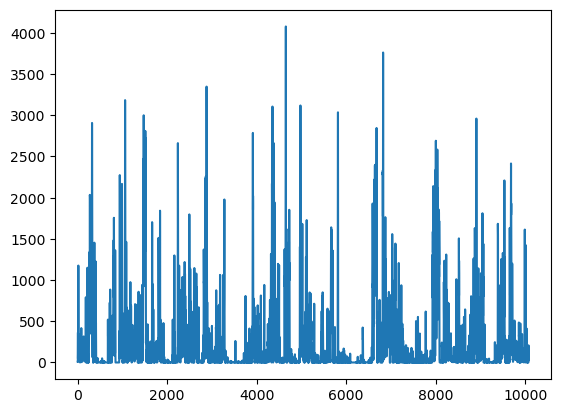

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000017794C0>

In [55]:
df1=copy(transpose(convert(Matrix, avgAct)))
nVec = 1440*7
A = reshape(copy(transpose(convert(Matrix, avgAct))), nVec, 1);
plot(A)

## Function `getbio()`

`getbio()` returns a tuple containing the bio information of an individual.

In [89]:
function getbio(dfBio::DataFrame)
    dem = NamedTuple{(:id, :age, :height, :weight, :startdate),
            Tuple{Int64, Int64, Float64, Float64, DateTime}}((
            parse(Int64, dfBio[1, :Value]), # id
            parse(Int64, dfBio[2, :Value]), # age
            parse(Float64, dfBio[4, :Value]), # height
            parse(Float64, dfBio[6, :Value]),  # weight
            parse(DateTime, dfBio[8, :Value]*"T"*dfBio[9, :Value]) # start date
            ))
    
    return dem
end

getbio (generic function with 1 method)

In [13]:
realpath(string(@__DIR__,listDir[1]))
myDir = abspath(string(@__DIR__,listDir[1]));
# Get the data list files from the directory myDir
(dataFiles, bioFiles) = ActStatData.filesNoNaN(myDir)
# Get any file and show columns of the data frame structure
df = ActStatData.readActivity(myDir*bioFiles[3]);
getbio(df).id

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


40

## Function getIndivID()
`getIndivID` returns the ID and group assignement of an infdicidual.

In [87]:
function getIndivID(fileName::String; actType = 1)
    dfBiorg = ActStatData.readActivity(fileName);
    return getbio(dfBiorg).id
end

getIndivID (generic function with 1 method)

In [15]:
idd = getIndivID(myDir*bioFiles[3])

40

In [16]:
idd = Array{Int64, 1}(undef, 3)

3-element Array{Int64,1}:
 232010592
 396427456
 379700048

## Function `getStatAct()`

Builds a average activity matrix, MxN where M is numbers of epochs (1440 minutes) and N is the number of subjects for a given visit (e.g. Baseline, 32 Week Gestation, 6 Weeks PP...).   
It also saves the matrix in the corresponding  vistit folder. Finally, it returns the average activity for all subjects and the standard deviation.

In [85]:
function getStatActi(dirName::String, actType::Int64 = 1)
    # Get the data list files from the directory myDir
    (dataFiles, bioFiles) = ActStatData.filesNoNaN(dirName);
    
    # Total number of files in the directory dirName
    numFiles = length(dataFiles)
    
    # Keep ID of individual
    vecID = Array{Int64, 1}(undef, numFiles)
    
    nMin = 60
    # Create average activity matrix 
    avgActMat = Array{Float64, 2}(undef, Int(1440/nMin), numFiles)
    
    for  i = 1:numFiles
        # Get average Activity over 7 days
        avgAct = getIndivMatAct(dirName * dataFiles[i], actType = actType)
                
        # Add the new column in the average activity matrix form 00:00 to 23:59
        avgActMat[:, i] = avgAct[:]
        
        # Collect ID
        vecID[i] = getIndivID(dirName * bioFiles[i])    
    end
        
    return avgActMat, vecID
    
end

getStatActi (generic function with 2 methods)

## Function `mat2dfAct()`
`mat2dfAct()` returns a dataframe containing activity datafor each min and for each individual.

In [107]:
function mat2dfAct(mat::Array{Float64, 2}, vecID::Array{Int64, 1})
    
    # Transpose the matrix: ID rowwise and time columnwise
    mat = copy(transpose(mat))
    
#     d = Dates.Time("00:00", "HH:MM"):Dates.Minute(1):Dates.Time("00:00", "HH:MM") + Dates.Hour(24) - Dates.Minute(1)
    d = Dates.Time("00:00", "HH:MM"):Dates.Minute(60):Dates.Time("00:00", "HH:MM") + Dates.Hour(24) - Dates.Minute(1)
    d = string.(collect(d))
    for i= 1:length(d) d[i] = d[i][1:5] end
    d = "T".*replace.(d, ":"=> "h") 
    df  = DataFrame([@view(mat[:, i]) for i in 1:size(mat, 2)], Symbol.(d))
    
    insertcols!(df, 1, :StudyID => vecID)
    
    return df 
    
end

mat2dfAct (generic function with 1 method)

In [19]:
mat1 = [1 2 3; 4 5 6]
headerstr = ["a"; "b"; "c"]

3-element Array{String,1}:
 "a"
 "b"
 "c"

In [21]:
mat1 = rand(0:10,(1440, 300));

## Function `nonunique()`

`nonunique()` returns an array containing all the elements that appear at least twice in its input.

In [96]:
function nonunique!(x::AbstractArray{T}) where T
    sort!(x)
    duplicatedvector = T[]
    for i=2:length(x)
        if (isequal(x[i],x[i-1]) && (length(duplicatedvector)==0 || !isequal(duplicatedvector[end], x[i])))
            push!(duplicatedvector,x[i])
        end
    end
    duplicatedvector
end

nonunique! (generic function with 1 method)

In [27]:
tt = [ 1; 2; 3; 2; 4; 5]

6-element Array{Int64,1}:
 1
 2
 3
 2
 4
 5

In [79]:
nonunique2!(tt)

1-element Array{Int64,1}:
 2

In [80]:
tt

6-element Array{Int64,1}:
 1
 2
 2
 3
 4
 5

## Write Script to generate csv data

Set the list of the visit directories relative path.

In [76]:
# List of visit directories
listDir = ["/../../../data/Baseline Visit Data/";
           "/../../../data/32 Week Gestation Data/";
           "/../../../data/6 Week PP Data/";
           "/../../../data/6 Months PP Data/";
           "/../../../data/12 Months PP Data/"]
realpath(string(@__DIR__,listDir[1]))
myDir = abspath(string(@__DIR__,listDir[1]))

"C:\\git\\smartphysicalactivity\\data\\Baseline Visit Data\\"

Load the group assignment data.

In [77]:
# Load the group assignment information
groupFileName = realpath(string(@__DIR__, "/../../../data/Group/group_assignement.csv"))
global dfGroup = DataFrame!(CSV.File(groupFileName));
sort!(dfGroup);

Get the average activity data during one week for all individual.

In [90]:
# Get the data list files from the directory myDir
# (myData, myHeader) = ActStatData.filesNoNaN(myDir);
# myDir
# Get the matrix data
mat, vID = getStatActi(myDir);
size(mat)

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


(24, 273)

In [91]:
# Get the data list files from the directory myDir
    (dataFiles, bioFiles) = ActStatData.filesNoNaN(myDir);
    
    # Total number of files in the directory dirName
    numFiles = length(dataFiles)

There is no file with NA missing data in the following directory:
C:\git\smartphysicalactivity\data\Baseline Visit Data\


273

In [92]:
length(unique(dataFiles))

273

In [93]:
# Keep ID of individual
vID = Array{Int64, 1}(undef, numFiles) 
for  i = 1:numFiles
    # Collect ID
    vID[i] = getIndivID(myDir * bioFiles[i])    
end

In [94]:
sort!(vID);

In [97]:
vID[nonunique!(vID)]
findall(x -> x == 202, vID)

1-element Array{Int64,1}:
 32

In [98]:
length(unique(vID))

273

In [99]:
vID[30:39]

10-element Array{Int64,1}:
 192
 197
 202
 203
 213
 214
 218
 220
 224
 225

Idendtify if every ID are unique.

In [100]:
length(vID) == length(unique(vID))

true

In [101]:
vID[nonunique!(vID)]

Int64[]

In [102]:
show(length(vID))
show(length(unique(vID)))

273273

In [103]:
# Get Group assignment for the selected ID
myDf = DataFrame(StudyID = vID)
dfAct = leftjoin(myDf, dfGroup, on = :StudyID)
first(dfAct, 3)

,StudyID,Arm
,Int64,Int64?
1,1,1
2,4,3
3,40,2


In [108]:
# Convert matrix to data frame
myDf = mat2dfAct(mat, vID)
first(myDf, 3)

,StudyID,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,T07h00
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1847.33,2348.83,2302.67,640.5,8954.83,36296.5,21698.8,28110.5
2,4,810.857,640.857,861.429,1477.43,18658.1,41676.3,24472.0,21237.7
3,40,161.143,129.0,684.0,1248.0,819.0,7589.29,12125.7,19641.0


In [109]:
df = leftjoin(dfAct, myDf, on = :StudyID)

,StudyID,Arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00
,Int64,Int64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,1,1,1847.33,2348.83,2302.67,640.5,8954.83,36296.5,21698.8
2,4,3,810.857,640.857,861.429,1477.43,18658.1,41676.3,24472.0
3,40,2,161.143,129.0,684.0,1248.0,819.0,7589.29,12125.7
4,43,2,1525.43,1008.43,1497.71,596.143,2173.86,1759.29,3420.57
5,44,3,2230.71,1398.29,2921.86,874.143,532.429,654.143,391.0
6,48,1,3508.71,5055.14,1282.71,6525.29,8762.57,12534.0,22095.0
7,49,3,3549.83,7067.83,4074.0,1245.33,773.333,1100.5,11072.2
8,53,3,2567.5,2059.0,821.0,1168.0,4862.5,15068.5,21780.8
9,54,1,1307.71,95.8571,2187.0,4025.0,3633.86,3374.71,14540.0


In [110]:
# Find missing data
findall(x -> ismissing(x), df.Arm)

1-element Array{Int64,1}:
 120

In [111]:
#Remove missing
dropmissing!(df);

In [115]:
df

,StudyID,Arm,T00h00,T01h00,T02h00,T03h00,T04h00,T05h00,T06h00,T07h00
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,1,1847.33,2348.83,2302.67,640.5,8954.83,36296.5,21698.8,28110.5
2,4,3,810.857,640.857,861.429,1477.43,18658.1,41676.3,24472.0,21237.7
3,40,2,161.143,129.0,684.0,1248.0,819.0,7589.29,12125.7,19641.0
4,43,2,1525.43,1008.43,1497.71,596.143,2173.86,1759.29,3420.57,12241.3
5,44,3,2230.71,1398.29,2921.86,874.143,532.429,654.143,391.0,6029.57
6,48,1,3508.71,5055.14,1282.71,6525.29,8762.57,12534.0,22095.0,21324.7
7,49,3,3549.83,7067.83,4074.0,1245.33,773.333,1100.5,11072.2,13863.8
8,53,3,2567.5,2059.0,821.0,1168.0,4862.5,15068.5,21780.8,15829.3
9,54,1,1307.71,95.8571,2187.0,4025.0,3633.86,3374.71,14540.0,25837.4


# Save the activity matrix data

In [116]:
csvFileName = string(@__DIR__,"/../../../data/fda/","mBaseline2.csv")
CSV.write(csvFileName, df ; writeheader=true)

"C:\\git\\smartphysicalactivity\\develop\\test\\FDA/../../../data/fda/mBaseline2.csv"

In [114]:
# Since Matrix does not support Tables.jl interface, we need to convert the matrix to dataframe 
# in order to save it in csv file with the CSV.jl package
# myDf = DataFrame(transpose(myMat));
# Save the activity matrix data
"/../../../data/Baseline Visit Data/"
csvFileName = realpath(string(@__DIR__,"/../../../data/fda"))*"/mBaseline2.csv"
CSV.write(csvFileName, df ; writeheader=false)

"C:\\git\\smartphysicalactivity\\data\\fda/mBaseline2.csv"

In [34]:
#  @btime A = @view(mat[:,:]).+1
@btime A = mat.+1

  1.432 ms (4 allocations: 3.01 MiB)


1440×274 Array{Float64,2}:
  5.83333   19.0      1.0       6.28571  …   4.85714  12.7143   109.333
  1.0       24.7143   1.0       6.28571      2.57143  19.4286    85.1667
  2.83333   45.0      1.0       8.14286      1.57143   9.0       34.6667
  4.5       53.4286   1.0      30.5714       1.57143  12.0       30.5
  4.5       35.2857   1.0      32.5714       2.57143   5.28571   43.0
  5.66667   21.1429   1.0      30.7143   …   3.14286   6.0       64.6667
  4.0       14.7143   1.0       3.0          3.57143  13.1429    97.5
 28.8333    10.1429   1.0       1.0          3.14286  13.1429    85.0
 25.8333    14.7143   3.71429  41.7143       2.0      32.8571   103.667
 25.8333    13.7143   3.71429  41.7143       1.57143  40.8571   135.333
  1.0       45.2857   8.71429  43.4286   …   1.57143  66.4286   178.833
  4.5       36.7143   6.0      13.0          5.28571  46.1429   193.167
 15.8333    42.2857   6.0      13.0          9.0      49.8571   126.5
  ⋮                                      ⋱  

##### # Get the data list files from the directory myDir

In [1]:
using BenchmarkTools

In [55]:
using BenchmarkTools

# declare global-scope variables as constants, otherwise the compiler can't
# stably infer the variable's type
const L = 500 # integer literals in Julia don't require conversion
const v3 = [[rand(L) for i = 1:L] for j = 1:L]
const vec_mat = Vector{Matrix{Float64}}(L) #Array{Matrix}(L, L);
# const arr = rand(L, L, L);

# fill!(vec_mat, rand(L, L));

# @btime v3 .+= 1.0
# @btime vec_mat .+= 1.0
# @btime arr .+= 1.0


MethodError: MethodError: no method matching Array{Array{Float64,2},1}(::Int64)
Closest candidates are:
  Array{Array{Float64,2},1}() where T at boot.jl:424
  Array{Array{Float64,2},1}(!Matched::UndefInitializer, !Matched::Int64) where T at boot.jl:405
  Array{Array{Float64,2},1}(!Matched::UndefInitializer, !Matched::Int64...) where {T, N} at boot.jl:411
  ...

In [19]:
function test()
    L = Int(1e4)
    M = N = 30
    vec_vec_vec = Array{Vector{Vector{Float64}}}(undef, L);
    for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;
    vec_mat = Array{Matrix{Float64}}(undef, L);
    fill!(vec_mat, rand(M, N));
    arr = rand(L, M, N);
    @time  for i = 1:L for j = 1:M for k = 1:N vec_vec_vec[i][j][k] += 1; end; end; end; 
    @time  for i = 1:L for j = 1:M for k = 1:N vec_mat[i][j,k] += 1; end; end; end; 
    @time  for k = 1:N for j = 1:M for i = 1:L arr[i,j,k] += 1; end; end; end; 
end
test()

  0.011724 seconds
  0.007106 seconds
  0.012184 seconds


In [20]:

function test()
    L = Int(1e4)
    M = N = 30
    vec_vec_vec = Array{Vector{Vector{Float64}}}(undef, L);
    for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;
    vec_mat = Array{Matrix{Float64}}(undef, L);
    fill!(vec_mat, rand(M, N));
    arr = rand(L, M, N);
    @time @inbounds for i = 1:L, j = 1:M, k = 1:N vec_vec_vec[i][j][k] += 1 end
    @time @inbounds for i = 1:L, k = 1:N, j = 1:M vec_mat[i][j,k] += 1 end
    @time @inbounds for k = 1:N, j = 1:M, i = 1:L arr[i,j,k] += 1 end
end
test()
# k = 1:N, j = 1:M, i = 1:L

  0.011415 seconds
  0.006783 seconds
  0.006540 seconds


In [2]:
Int(1440/60)

24